# Extract and explore information from forum data provided by Mumsnet. <br> Viktoria, June 2021

### Part 1. Explore user behaviour on the different forums: <br> (i) which forums are most popular/most likely to recommend ? <br> (ii) when do people visit these forums? <br> (iii) scrape the URLs and extract product category

### Part 2. Content of conversations on different forums: <br> (i) Quick look at the titles (wordcloud) <br> (ii) Quick look at the messages (plot the most frequent word combinations)

### Part 3. Predictive modelling: Do the words they use in the message predict the type of product they will recommend?

In [227]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import time
import random
from IPython.display import clear_output
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, make_scorer, log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import randint as sp_randint

pd.options.display.max_rows = 8000
pd.options.mode.chained_assignment=None

In [2]:
#Define directories

base = '/Users/Viktoria/Desktop/Mumsnet_Forumdata'
raw = os.path.join(base, 'Raw_data')
viz = os.path.join(base, 'Data_visualisation')
preproc = os.path.join(base, 'Preprocessed_data')

os.chdir(raw)

In [3]:
#Import data
forumdata = pd.read_csv('mumsnet_test.csv')
print(len(forumdata))
forumdata.head()

1463


,ID,Title,Forum,DateTime,Message
0,4160382,AIBU to ask where your buy your underwear?,am_i_being_unreasonable,2021-02-09 12:48:05.000 +0000,I bought these off Amazon - comfiest knickers ...
1,4159534,DH lost laptop and now assignment will be late,am_i_being_unreasonable,2021-02-08 20:32:56.000 +0000,Yay! Glad you found the laptop!\n\nPerhaps hav...
2,4160824,Best padded playmat company?,parenting,2021-02-09 21:28:03.000 +0000,Learn from my mistakes- they pull the tile kin...
3,4160824,Best padded playmat company?,parenting,2021-02-09 22:03:36.000 +0000,I got this one from Amazon:\n\n[[https://www.a...
4,4154319,What fun stuff can we get delivered for the fa...,_chat,2021-02-04 23:13:42.000 +0000,Chocolate fondue is cheaper than buying a choc...


In [4]:
#Anything missing?
forumdata.isnull().values.any()

False

In [5]:
#How many forums does the data come from?
len(forumdata.Forum.unique())

85

In [6]:
#How many posts on each forum?
#forumdata.Forum.value_counts()

In [7]:
#Do all of these messages include a link?
recs = [m for m in forumdata.Message if 'amazon' in m]
print('Total number of messages: ', len(forumdata), '\nMessages with links: ', len(recs))

Total number of messages:  1463 
Messages with links:  1450


# Part 1. Explore user behaviour on the different forums

## 1.1. Which forums are the most likely to contain amazon recommendations?

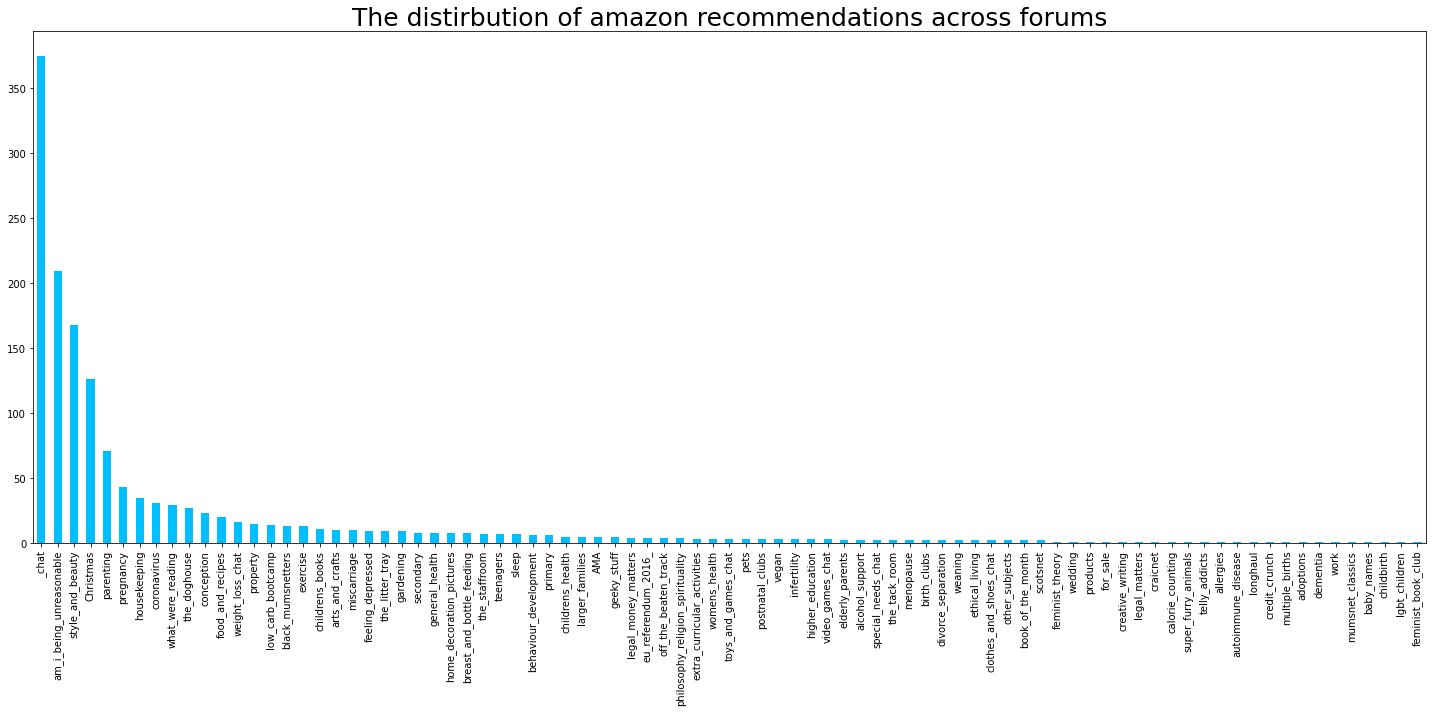

In [8]:
os.chdir(viz)

fora = forumdata.Forum.value_counts()
numfora = len(fora)

plt.figure(figsize=(20,10))
fora.plot.bar(width=0.5, color=(0, 0.75, 1)) #deep skye blue
plt.title('The distirbution of amazon recommendations across forums', fontsize=25)
plt.tight_layout()
plt.savefig('Number of messages across forums.pdf')

## 1.2. When are people most likely to recommend products?


In [9]:
#Extract the hour:minute:second information from the timestamps

def get_hour(string):
    
    try:
        
        #Find the pattern hh:mm:ss
        time = re.search(r'[0-9]{2}\:[0-9]{2}\:[0-9]{2}', string).group() #gives None if no hits
        
        #Covert to a fraction between 0-24
        hour = int(time.split(':')[0])
        minute = int(time.split(':')[1])
        second = int(time.split(':')[2])
        TimeInHour = (hour*3600+minute*60+second)/3600
        
    except:
        TimeInHour = 'unknown'
        
    return TimeInHour

In [10]:
forumdata['Hours'] = forumdata['DateTime'].apply(get_hour)

In [11]:
forumdata.head()

,ID,Title,Forum,DateTime,Message,Hours
0,4160382,AIBU to ask where your buy your underwear?,am_i_being_unreasonable,2021-02-09 12:48:05.000 +0000,I bought these off Amazon - comfiest knickers ...,12.801389
1,4159534,DH lost laptop and now assignment will be late,am_i_being_unreasonable,2021-02-08 20:32:56.000 +0000,Yay! Glad you found the laptop!\n\nPerhaps hav...,20.548889
2,4160824,Best padded playmat company?,parenting,2021-02-09 21:28:03.000 +0000,Learn from my mistakes- they pull the tile kin...,21.467500
3,4160824,Best padded playmat company?,parenting,2021-02-09 22:03:36.000 +0000,I got this one from Amazon:\n\n[[https://www.a...,22.060000
4,4154319,What fun stuff can we get delivered for the fa...,_chat,2021-02-04 23:13:42.000 +0000,Chocolate fondue is cheaper than buying a choc...,23.228333


In [12]:
len(forumdata[forumdata.Hours=='unknown'])

0

In [13]:
times = forumdata.sort_values(by=['Hours'])
times = times.reset_index(drop=True)
times.head()

,ID,Title,Forum,DateTime,Message,Hours
0,4119327,Share your toys hits and misses here! (toddler...,parenting,2020-12-30 00:00:11.000 +0000,"Magnetic tiles have been a huge hit here too, ...",0.003056
1,4156404,Chick lit which ISNâ€™T first and foremost a r...,_chat,2021-02-06 00:02:36.000 +0000,[[https://www.amazon.co.uk/Prep-Curtis-Sittenf...,0.043333
2,4120949,Thread to discuss foreign reading,what_were_reading,2021-01-05 00:02:49.000 +0000,this one?\n[[https://www.amazon.co.uk/Great-Fr...,0.046944
3,4128158,What age did you get your toddler a pillow,parenting,2021-01-07 00:03:06.000 +0000,"I just gave dd a toddler pillow two days ago, ...",0.051667
4,4109377,Best fake AirPods please,Christmas,2020-12-19 00:05:09.000 +0000,If they don't have to look identical [[https:/...,0.085833


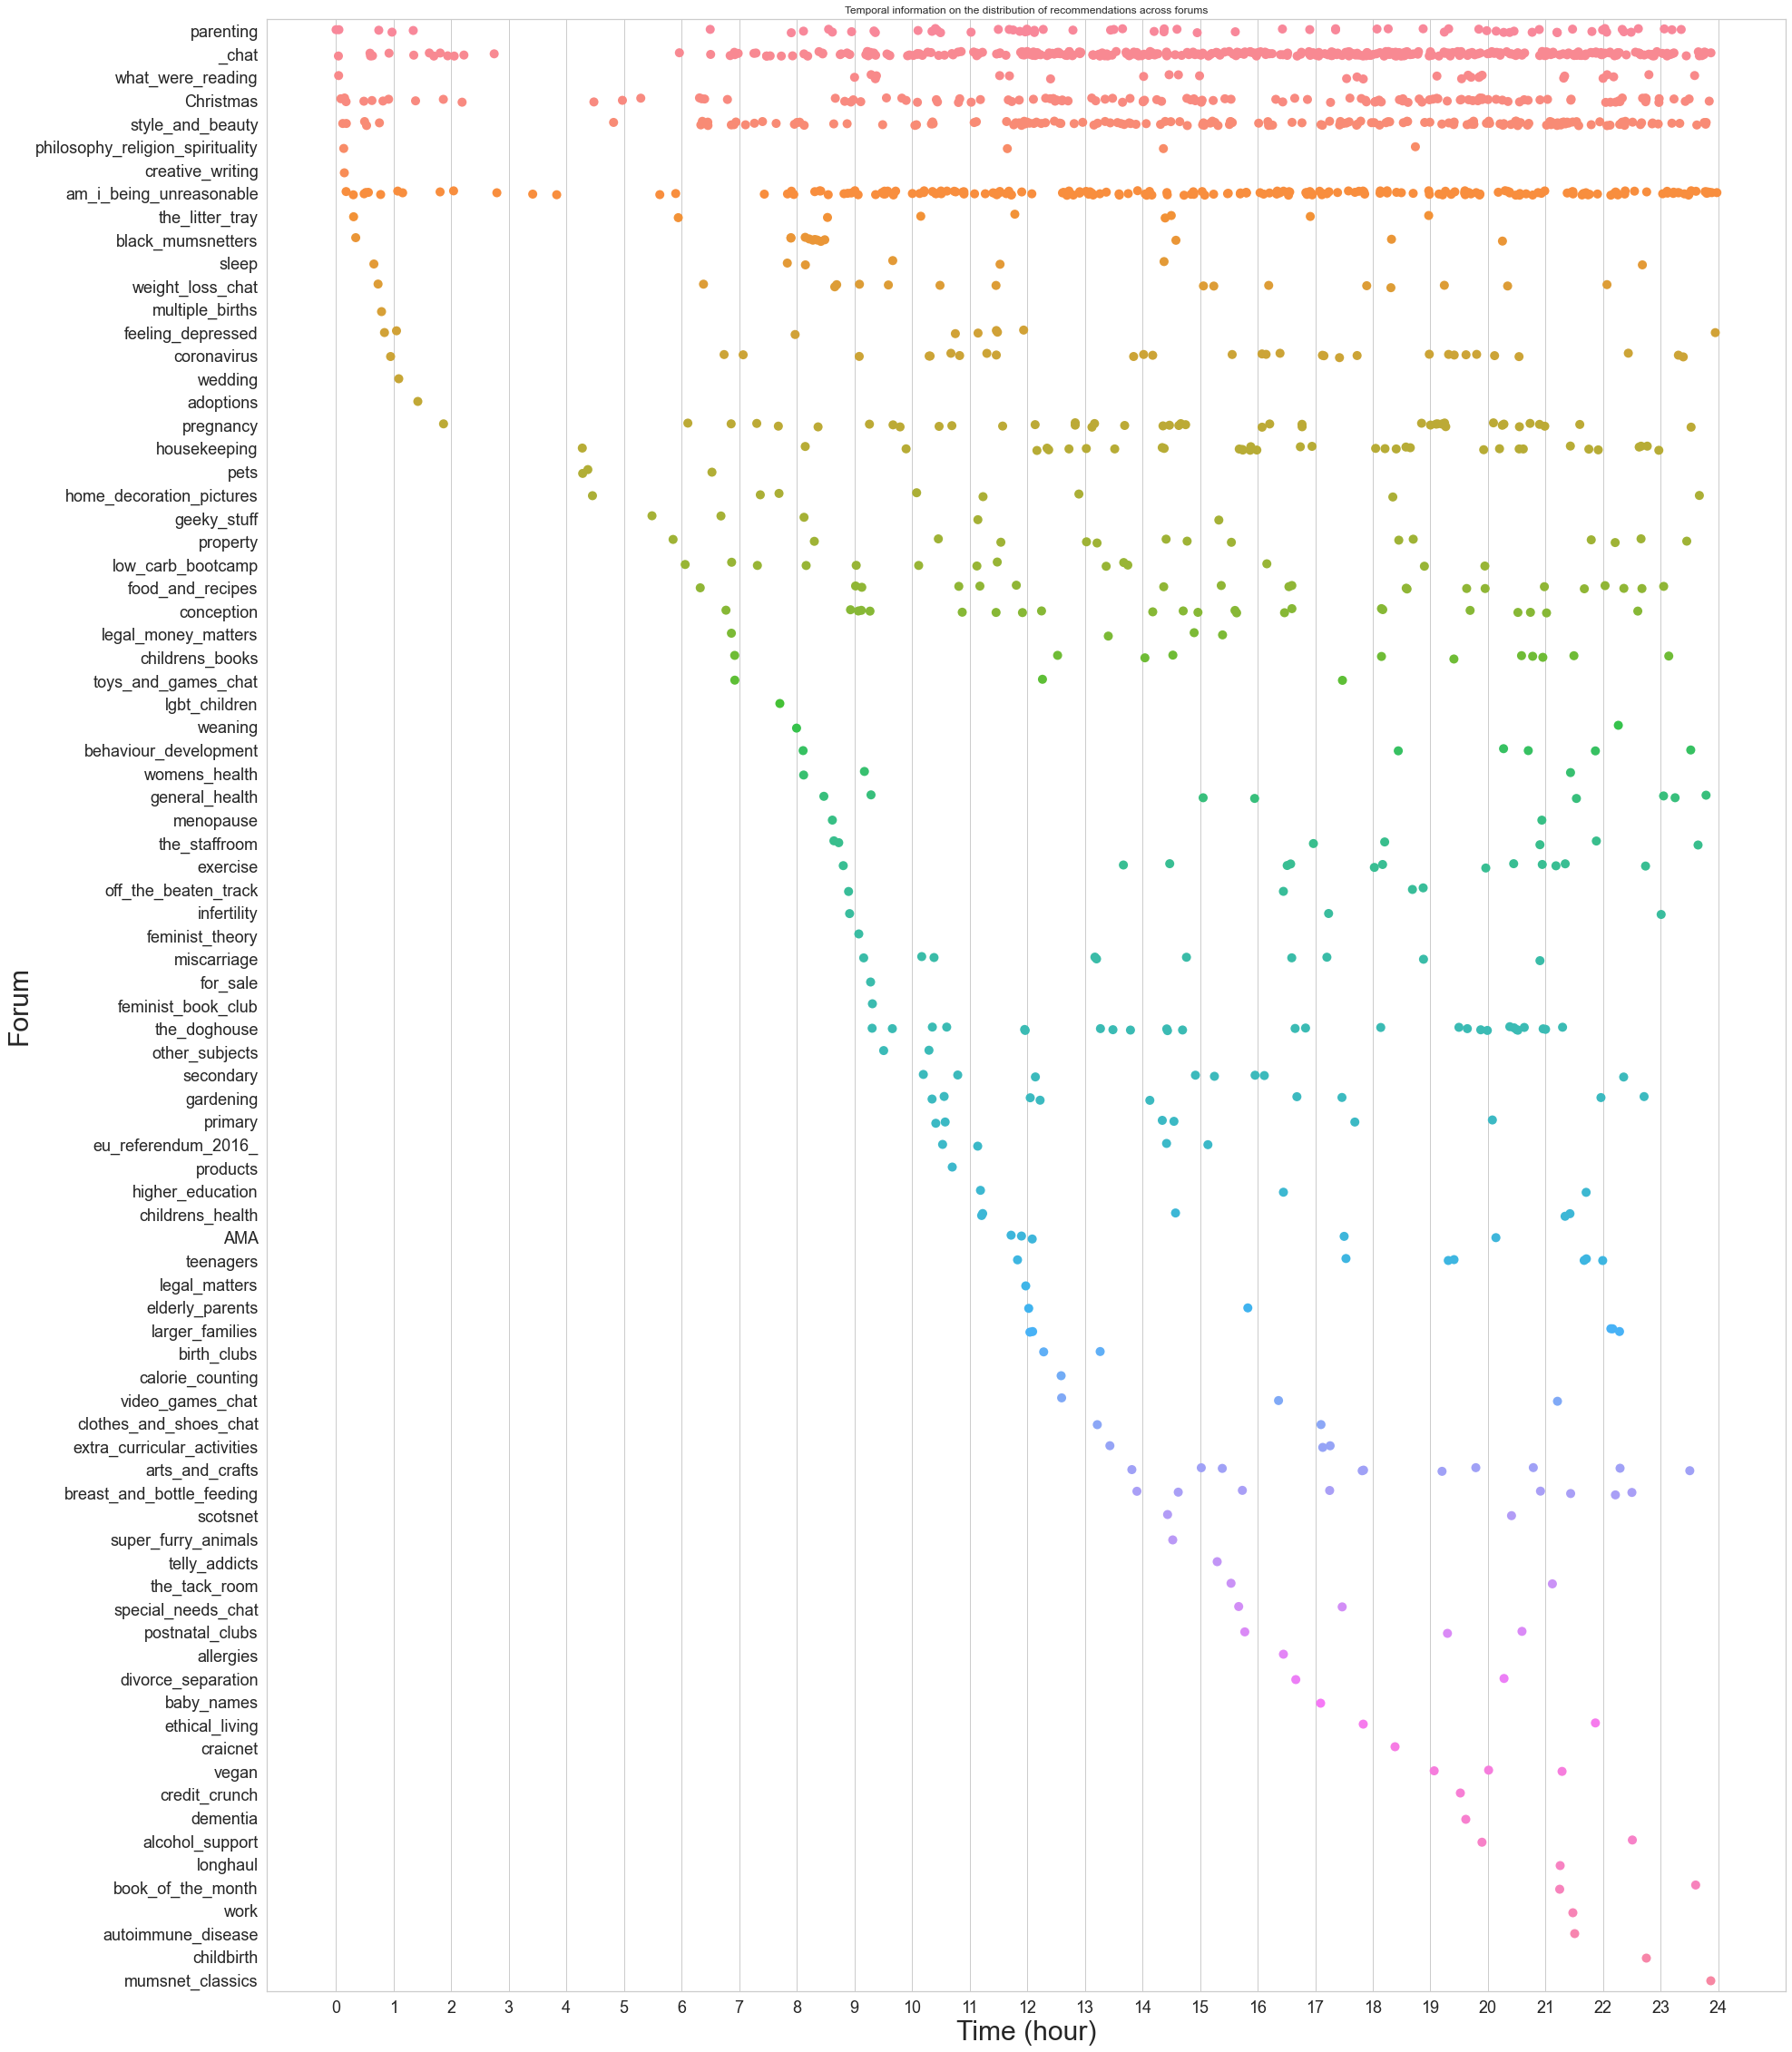

In [14]:
#Plot the time recommendations are made on each forum

os.chdir(viz)

sns.set_theme(style='whitegrid', palette='muted')
plt.figure(figsize=(30,40))

ax = sns.stripplot(data=times, x = 'Hours', y = 'Forum', s=10)

ax.set_xlabel('Time (hour)', fontsize=30)
ax.set_ylabel('Forum', fontsize=30)
ax.tick_params(labelsize=18)
ax.set_xticks(range(0,25,1))

plt.title('Temporal information on the distribution of recommendations across forums')
plt.savefig('Time of recommendations.pdf')

# Part 2. What is it that people talk about?

In [15]:
#How many unique titles are there?
print('Total number of messages: ', len(forumdata), '\nNumber of unique titles: ', len(forumdata.Title.unique()))

Total number of messages:  1463 
Number of unique titles:  1037


## 2.1. Have a quick look at the titles



In [16]:
#Text cleaning I. Lemmatization

def lemmatize(content_as_words):
    
    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {'J': wordnet.ADJ,
                    'N': wordnet.NOUN, 
                    'V': wordnet.VERB,
                    'R': wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    lemma = []
    subset = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in content_as_words]
    lemma.extend(subset)
    
    return lemma

In [17]:
#Text cleaning II. Final text cleaning
#rm everything except latin letters, lowercase, lemmatize, rm stopwords, rm non-English words, rm very short words

def clean_text(content):
    
    if type(content) == bytes:
        content = content.decode('utf-8')
    content = re.findall(r'[a-zA-Z]+', content)
    content = [c.lower() for c in content]
    
    #Lemmatize. This will return a list of 1 item, i.e. the lemmatized text as string
    lemma = lemmatize(content)
    
    #rm non-English words and stop-words
    en_words = set(nltk.corpus.words.words())
    stop_words = [s for s in stopwords.words('english')]
    content = [c for c in content if c in en_words and c not in stop_words]
    
    #rm very short words
    content = [c for c in content if len(c)>=3]
    
    #join it back into a tidy string of words
    content = ' '.join([c for c in content])
    
    return content

In [18]:
#Lemmatize the titles

titles = forumdata.Title.tolist()
titles = ' '.join([t for t in titles])
tidy_titles = clean_text(titles)

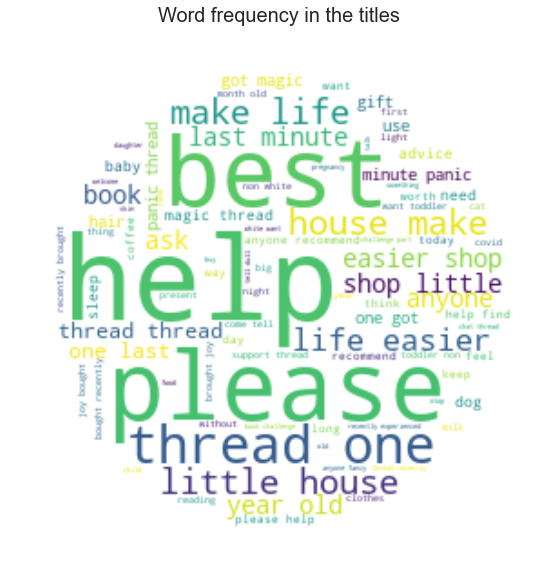

In [19]:
# Word cloud with the title words

os.chdir(viz)

plt.figure(figsize=(10,10))
x,y = np.ogrid[:300, :300]
mask = (x - 150)**2 + (y - 150)**2 > 130**2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color='white', repeat=True, mask=mask)
wc.generate(tidy_titles)

plt.title('Word frequency in the titles', fontsize= 20)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.savefig('Ttitles_WordCloud.png')

## 2.2. Have a quick look at the messages

### Title words suggest giving/receiving advice. Are they recommending different things or similar things on the forums? Plot the n most common word combinations on each forum.

In [20]:
#Clean the message data

forumdata['Cleaned_Message'] = forumdata['Message'].apply(clean_text)

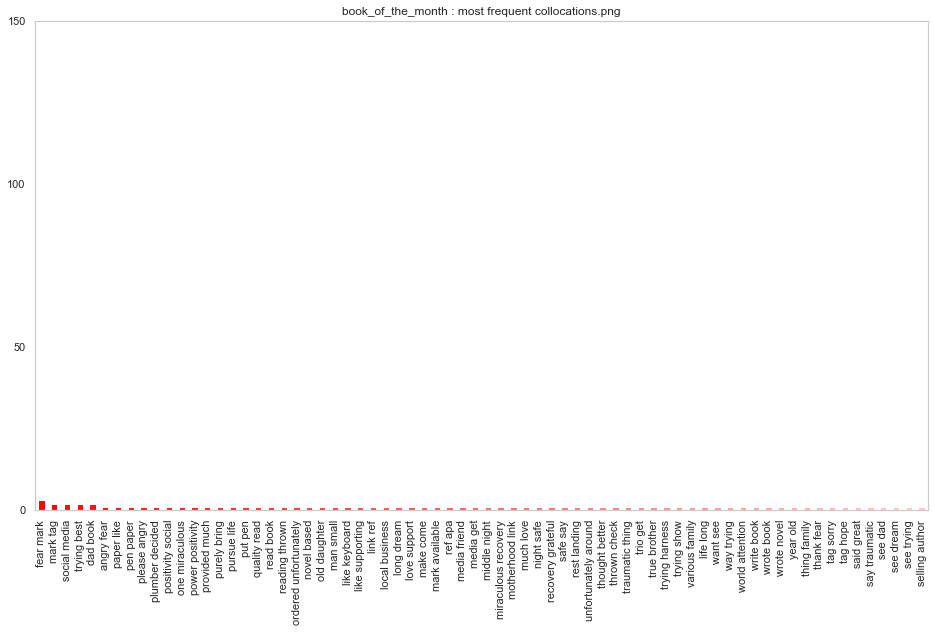

In [25]:
#Plot the most frequent collocations on each forum
os.chdir(os.path.join(viz, 'Frequent_collocations'))

#number of collocations to display
n=70

#n words in a collocation
lencol = 2

#length of time to display each plot for
waittime = 15

#Get a list of nice colours in a random order
cmap = plt.get_cmap('prism')
cmaplist = [cmap(i) for i in range(cmap.N)]
colours = random.sample(cmaplist, len(cmaplist))

#Reduce the opacity as the items become less frequent
alpha = [x for x in np.arange(0.2, 1, 0.8/n)]
alpha = alpha[::-1]

#go through all the forums
for i,f in enumerate(forumdata.Forum.unique()):
    
    this_forum = forumdata[forumdata.Forum==f]
    texts = []
    texts.extend(''.join(m for m in this_forum['Cleaned_Message'][r]) for r,v in this_forum.iterrows())
    
    #Create a DTM and only keep collocations of the desired length
    cv = CountVectorizer(ngram_range=(1,lencol))
    cv.fit(texts)
    texts_transformed = cv.transform(texts)
    n_data = pd.DataFrame(texts_transformed.toarray(), columns = cv.get_feature_names())
    counts = pd.DataFrame([n_data.sum(axis=0)])
    counts = counts.drop([col for col in counts.columns if len(col.split())<lencol], axis='columns')
    
    #n most frequent collocations
    collocations = counts.transpose() #columns to rows
    collocations = collocations.squeeze() #convert to series
    collocations = collocations.astype('float')
    collocations = collocations.sort_values(ascending=False)
    collocations = collocations[0:n]
    
    #clear the previous figure
    clear_output()
    
    #new colours
    r = colours[i][0]
    g = colours[i][1]
    b = colours[i][2]
    c = [(r,g,b,a) for a in alpha]
    
    titlestr = f + ' : most frequent collocations'
    
    #create the current figure
    plt.figure(figsize=(16,9))
    ax = collocations.plot.bar(width=0.5, color=c)
    ax.set_yticks(range(0,200,50))
    ax.grid(False)
    plt.title(titlestr + '.png')
    
    plt.show()
    time.sleep(waittime)
    
    #last plot
    if i == len(forumdata):
        clear_output()
    
    


## 2.3. What type of products are they recommending? Extract product category from urls

In [52]:
#Extract the URLs: a list of URLs in the post are added as a column

forumdata['URLs'] = ''

for r,v in forumdata.iterrows():
    message = forumdata.loc[r, 'Message']
    hits = re.findall(r'\[\[(.*?)\]\]', message)
    forumdata['URLs'][r] = hits

In [57]:
forumdata.loc[11, 'URLs']

['https://www.amazon.co.uk/Why-Love-Matters-Affection-Shapes/dp/1583918175?tag=mumsnetforu03-21']

In [70]:
#Find out which post recommends which product(s). The product category mentioned in the post is added as a column.

def extract_category(urls):
    
    #all the recommended categories in the post
    cats = []
    
    for url in urls: #in case >1 url in the post
        
        try: 
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'})
            soup = BeautifulSoup(response.text, 'html.parser')
            findme = ' '.join(re.findall(r'Amazon.co.uk:\s.*\n+', soup.text)) #product category is after Amazon.co.uk:
            category = findme.split(':')[-1] #the last thing before the newline is the category, e.g. Books/Baby, etc
            category = re.sub(r'\n+', '', category)
            category = category.strip()
            print(category)
            cats.append(category)
            
            time.sleep(random.randint(20,60))
            
        except:
            pass
        
    return cats

In [ ]:
#Scrape the product category from the internet. Halve the data to save time.

#products = forumdata[:700]

#products['Product_category'] = [m for m in map(extract_category, tqdm(products.URLs))]

#Save this for further analyses
#os.chdir(preproc)
#products.to_csv('Product_information.csv')

In [179]:
#in case you are importing from the csv: the lists are turned into strings. Turn them back

products = pd.read_csv('Product_information.csv')
if type(products.loc[0, 'Product_category']) == str:
     products['Product_category'] = [eval(products.loc[i, 'Product_category']) for i,v in products.iterrows()]

# Part 3. Predictive modelling: Does message data predict product category?

## 3.1. Data cleaning

In [180]:
#Get rid of empty strings

for r,v in products.iterrows():
    
    cats = products.loc[r, 'Product_category']
    
    #delete empty
    cats = [c for c in cats if c != '']
    
    #delete if everything is empty
    if not cats:
        products = products.drop([r])
    
    #only keep multiple recs in a message if they are all the same category
    elif len(set(cats))>1:
        products = products.drop([r])
    
    else:
        products['Product_category'][r] = cats[0]
        
products = products.reset_index(drop=True)

In [ ]:
# See the product categories
counts = products.Product_category.value_counts()

In [ ]:
len(products.Product_category.unique())

In [207]:
#Remove the categories with very few instances

to_remove = counts[counts < 10].index
products['Product_category'].replace(to_remove, np.nan, inplace=True)
products = products.dropna()
products = products.reset_index(drop=True)

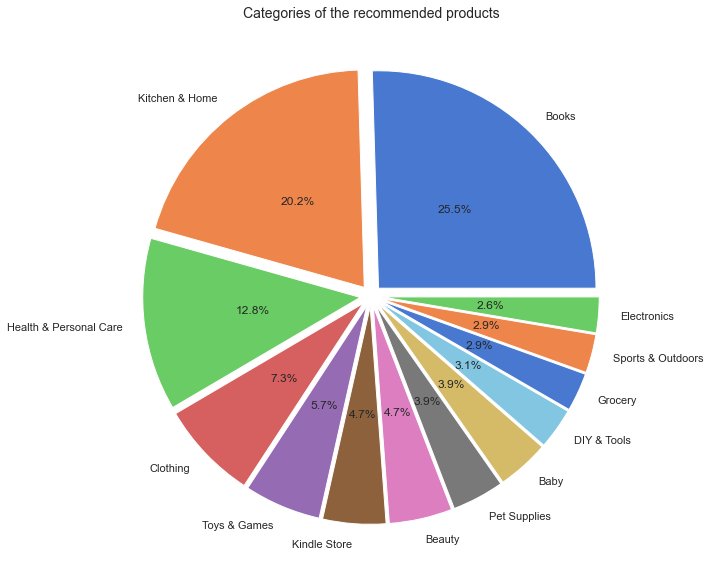

In [214]:
#Have a quick look at the categories

os.chdir(viz)

pie, ax = plt.subplots(figsize=[10,10])

counts = counts[counts > 10]
labels = counts.keys()
values = counts.values
plt.pie(x=values, autopct="%.1f%%", explode=[0.05]*len(counts), labels=labels, pctdistance=0.5)
plt.title('Categories of the recommended products', fontsize=14);
pie.savefig('Recommended_prodcuts.png')

## 3.2. Multiclass classification using the message data

In [218]:
#Prepare the data for modelling. Tfidf will control for corpus-specific stop words and message length.

cleaned_data = []
cleaned_data.extend(''.join(products['Cleaned_Message'][index]) for index, row in products.iterrows())

tf = TfidfVectorizer(ngram_range=(1,3), min_df = 10)

cleaned_data_transformed = tf.fit_transform(cleaned_data)

data_vector = pd.DataFrame(cleaned_data_transformed.toarray(),
                 columns=tf.get_feature_names())

data_vector.shape

(501, 245)

In [220]:
# Factorize the dependent variable

factor = pd.factorize(products['Product_category'])
products['Class'] = factor[0]
definitions = factor[1]

In [223]:
definitions

Index(['Clothing', 'Books', 'Baby', 'Kitchen & Home', 'Electronics',
       'Health & Personal Care', 'Office Products', 'DIY & Tools',
       'Sports & Outdoors', 'Pet Supplies', 'Toys & Games', 'Kindle Store',
       'Grocery', 'Beauty'],
      dtype='object')

In [230]:
#Grid search best parameters

X = data_vector
Y = products.Class

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,  random_state = 101)

# Number of trees in random forest
n_estimators = sp_randint(1, 1000)

#Number of features to consider at every split
max_features = sp_randint(1, len(X.columns))

# Minimum number of samples required to split a node
min_samples_split = sp_randint(2,100)

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
search_params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'min_samples_split': min_samples_split,
                 'bootstrap': bootstrap}

grid_search=RandomizedSearchCV(RandomForestClassifier(class_weight='balanced'),
                               n_iter=100,
                               param_distributions=search_params,
                               cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1),
                               n_jobs=-1)

In [ ]:
grid_search.fit(X_train,Y_train)

In [ ]:
print('The best Params to use are \n', grid_search.best_params_ )
print('Which gives the best cross validation score of', grid_search.best_score_ )

In [ ]:
#Results

best_params = grid_search.best_params_
random_forest = RandomForestClassifier(**best_params)

best_model = grid_search.best_estimator_
                        
Y_pred = best_model.predict(X_test)
Y_pred_label = definitions[Y_pred]

print(classification_report(Y_test, Y_pred_label))

importances = best_model.feature_importances_
#print(importances)

In [ ]:
print(accuracy_score(Y_test, Y_pred_label))